In [594]:
#export
# %matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('default')
import os.path
from os import path

from matplotlib.patches import Rectangle
pd.set_option('mode.chained_assignment', None)

# figsize(11, 9)

import scipy.stats as stats
from scipy.stats import linregress
# from nb_20_Dogcatcher import *
from nb_30_MultiSwitchpoint import *

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

### Make a conda environment for this with python 3.8
#pip3 install tensorflow--cpu==2.4.1
#pip3 install tensorflow_probability==0.12.1
# conda install -c conda-forge nb_conda_kernels
# conda install ipykernel

#pip3 install --user dbscan 

import tensorflow.compat.v2 as tf
# print(tf.__version__)
tf.enable_v2_behavior()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
# %matplotlib inline
import scipy.stats
#https://www.tensorflow.org/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection

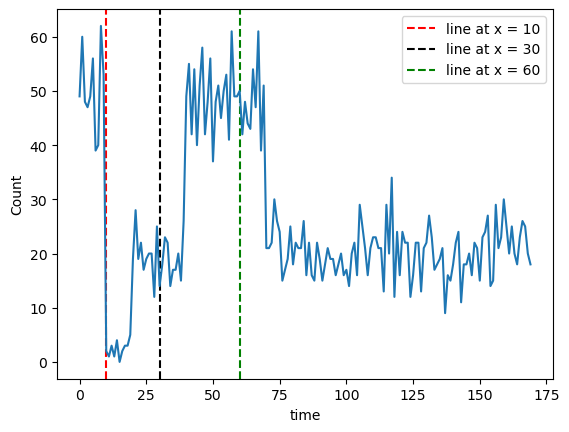

In [551]:
# true_rates = [40, 5, 20, 40]
# true_durations = [10, 20, 30, 40]

true_rates =     [50, 2,  20,50, 20]
true_durations = [10, 10, 20,30, 100]

observed_counts = np.concatenate([
  scipy.stats.poisson(rate).rvs(num_steps)
    for (rate, num_steps) in zip(true_rates, true_durations)
]).astype(np.float32)
# plt.axvline(x=10, color="black")
# plt.axvline(x=30, color="black")
# plt.axvline(x=60, color="black")

xcoords = [10, 30, 60]
# colors for the lines
colors = ['r','black','green']

for xc,c in zip(xcoords,colors):
    plt.axvline(x=xc, label='line at x = {}'.format(xc), c=c, linestyle='dashed')

plt.ylabel('Count')

plt.xlabel("time")
plt.legend()

plt.plot(observed_counts)
# plt.savefig('Toy_synthetic_data.png')

In [552]:
num_states = 3

initial_state_logits = np.zeros([num_states], dtype=np.float32) # uniform distribution

daily_change_prob = 0.05
transition_probs = daily_change_prob / (num_states-1) * np.ones(
    [num_states, num_states], dtype=np.float32)
np.fill_diagonal(transition_probs,
                 1-daily_change_prob)

print("Initial state logits:\n{}".format(initial_state_logits))
print("Transition matrix:\n{}".format(transition_probs))

Initial state logits:
[0. 0. 0.]
Transition matrix:
[[0.95  0.025 0.025]
 [0.025 0.95  0.025]
 [0.025 0.025 0.95 ]]


In [553]:
# Define variable to represent the unknown log rates.
trainable_log_rates = tf.Variable(
  np.log(np.mean(observed_counts)) + tf.random.normal([num_states]),
  name='log_rates')

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=initial_state_logits),
  transition_distribution=tfd.Categorical(probs=transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))

In [554]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
 return (tf.reduce_sum(rate_prior.log_prob(tf.math.exp(trainable_log_rates))) +
         hmm.log_prob(observed_counts))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

@tf.function(autograph=False)
def train_op():
  with tf.GradientTape() as tape:
    neg_log_prob = -log_prob()
  grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
  optimizer.apply_gradients([(grads, trainable_log_rates)])
  return neg_log_prob, tf.math.exp(trainable_log_rates)

In [555]:
for step in range(201):
  loss, rates = [t.numpy() for t in train_op()]
  if step % 20 == 0:
    print("step {}: log prob {} rates {}".format(step, -loss, rates))

print("Inferred rates: {}".format(rates))
print("True rates: {}".format(true_rates))

/Users/m/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow_probability/python/distributions/hidden_markov_model.py:497: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  warnings.warn(


step 0: log prob -690.6637573242188 rates [ 2.4541545 24.246244  54.26023  ]
step 20: log prob -543.8546142578125 rates [ 2.2799852 20.813967  46.6636   ]
step 40: log prob -538.86083984375 rates [ 2.3366606 20.218046  48.852703 ]
step 60: log prob -538.5769653320312 rates [ 2.3177593 19.975388  49.213196 ]
step 80: log prob -538.5232543945312 rates [ 2.3120928 20.084354  48.943226 ]
step 100: log prob -538.50830078125 rates [ 2.3151221 20.150784  48.980152 ]
step 120: log prob -538.5064086914062 rates [ 2.3160126 20.116634  49.012905 ]
step 140: log prob -538.506591796875 rates [ 2.3162837 20.128006  49.0017   ]
step 160: log prob -538.5064086914062 rates [ 2.316443 20.123913 48.99803 ]
step 180: log prob -538.5064086914062 rates [ 2.3165057 20.125423  48.997868 ]
step 200: log prob -538.5062255859375 rates [ 2.3164885 20.125053  48.998043 ]
Inferred rates: [ 2.3164885 20.125053  48.998043 ]
True rates: [50, 2, 20, 50, 20]


In [556]:
# Runs forward-backward algorithm to compute marginal posteriors.
posterior_dists = hmm.posterior_marginals(observed_counts)
posterior_probs = posterior_dists.probs_parameter().numpy()

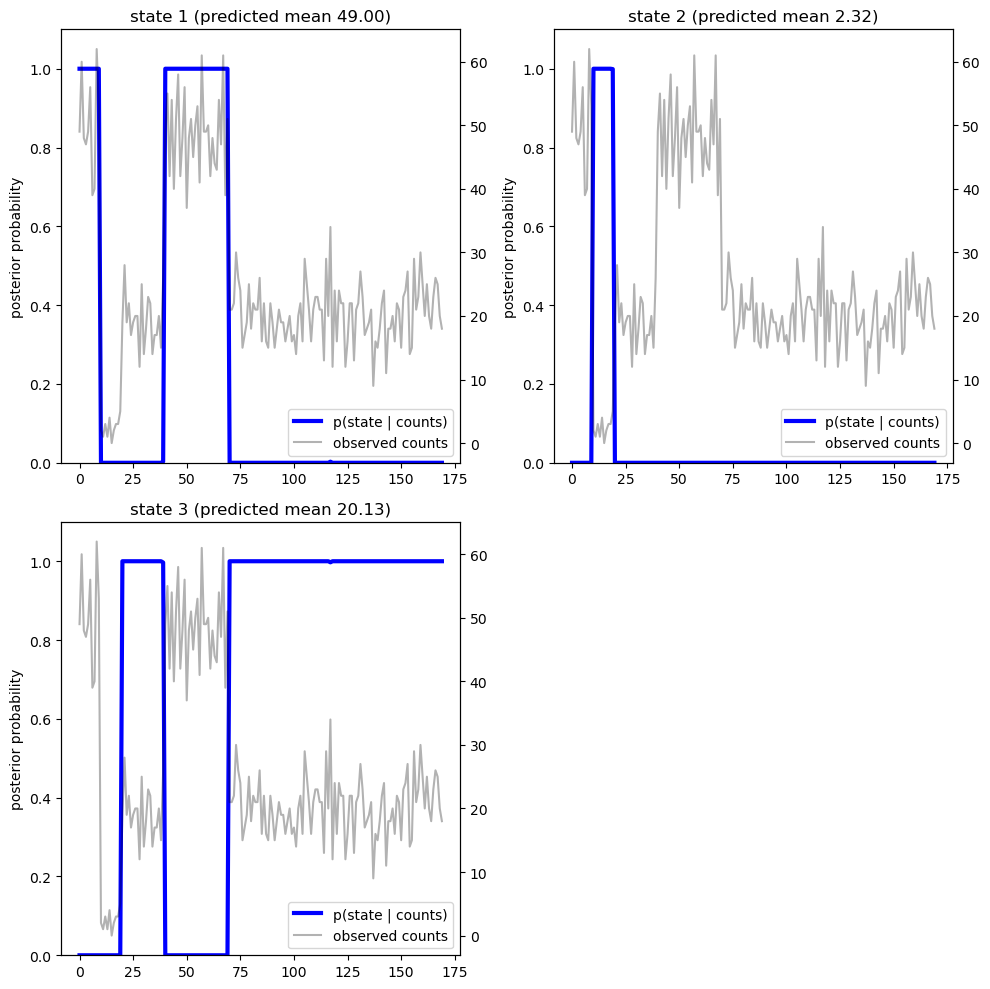

In [557]:
def plot_state_posterior(ax, state_posterior_probs, title):
  ln1 = ax.plot(state_posterior_probs, c='blue', lw=3, label='p(state | counts)')
  ax.set_ylim(0., 1.1)
  ax.set_ylabel('posterior probability')
  ax2 = ax.twinx()
  ln2 = ax2.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax2.set_title(title)
  ax2.set_xlabel("time")
  lns = ln1+ln2
  labs = [l.get_label() for l in lns]
  ax.legend(lns, labs, loc=4)
  ax.grid(True, color='white')
  ax2.grid(False)

fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1),
                     posterior_probs[:, 2],
                     title="state 1 (predicted mean {:.2f})".format(rates[2]))
plot_state_posterior(fig.add_subplot(2, 2, 2),
                     posterior_probs[:, 0],
                     title="state 2 (predicted mean {:.2f})".format(rates[0]))
plot_state_posterior(fig.add_subplot(2, 2, 3),
                     posterior_probs[:, 1],
                     title="state 3 (predicted mean {:.2f})".format(rates[1]))

plt.tight_layout()
# plt.savefig('Toy_synthetic_data_3_states.png')

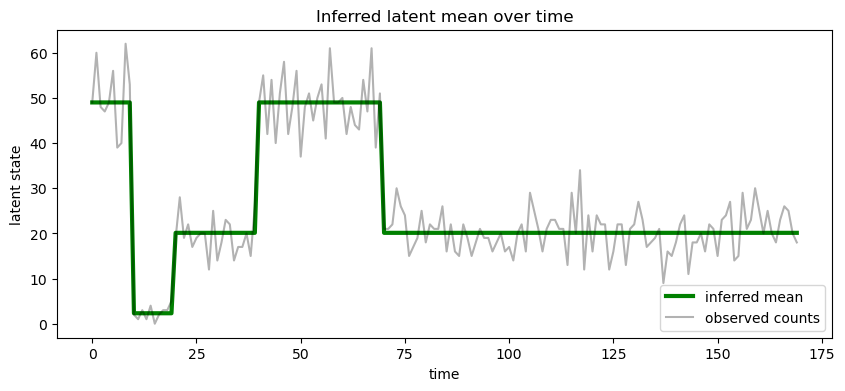

In [558]:
most_probable_states = np.argmax(posterior_probs, axis=1)
most_probable_rates = rates[most_probable_states]

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c='green', lw=3, label='inferred mean')
ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
ax.set_ylabel("latent state")
ax.set_xlabel("time")
ax.set_title("Inferred latent mean over time")
ax.legend(loc=4)
# plt.savefig('Toy_synthetic_data_3_inferred_latent.png')

In [559]:
# Unknown number of states


In [560]:
max_num_states = 6

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

  # Give probability exp(-100) ~= 0 to states outside of the current model.
  initial_state_logits = -100. * np.ones([max_num_states], dtype=np.float32)
  initial_state_logits[:num_states] = 0.

  # Build a transition matrix that transitions only within the current
  # `num_states` states.
  transition_probs = np.eye(max_num_states, dtype=np.float32)
  if num_states > 1:
    transition_probs[:num_states, :num_states] = (
        daily_change_prob / (num_states-1))
    np.fill_diagonal(transition_probs[:num_states, :num_states],
                     1-daily_change_prob)
  return initial_state_logits, transition_probs

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states+1):
  initial_state_logits, transition_probs = build_latent_state(
      num_states=num_states,
      max_num_states=max_num_states)
  batch_initial_state_logits.append(initial_state_logits)
  batch_transition_probs.append(transition_probs)

batch_initial_state_logits = np.array(batch_initial_state_logits)
batch_transition_probs = np.array(batch_transition_probs)
print("Shape of initial_state_logits: {}".format(batch_initial_state_logits.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
print("Example initial state logits for num_states==3:\n{}".format(batch_initial_state_logits[2, :]))
print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))

Shape of initial_state_logits: (6, 6)
Shape of transition probs: (6, 6, 6)
Example initial state logits for num_states==3:
[   0.    0.    0. -100. -100. -100.]
Example transition_probs for num_states==3:
[[0.95  0.025 0.025 0.    0.    0.   ]
 [0.025 0.95  0.025 0.    0.    0.   ]
 [0.025 0.025 0.95  0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]]


In [561]:
trainable_log_rates = tf.Variable(
    (np.log(np.mean(observed_counts)) *
     np.ones([batch_initial_state_logits.shape[0], max_num_states]) +
     tf.random.normal([1, max_num_states])),
     name='log_rates')

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=batch_initial_state_logits),
  transition_distribution=tfd.Categorical(probs=batch_transition_probs),
  observation_distribution=tfd.Poisson(log_rate=trainable_log_rates),
  num_steps=len(observed_counts))

In [562]:
rate_prior = tfd.LogNormal(5, 5)

def log_prob():
  prior_lps = rate_prior.log_prob(tf.math.exp(trainable_log_rates))
  prior_lp = tf.stack(
      [tf.reduce_sum(prior_lps[i, :i+1]) for i in range(max_num_states)])
  return prior_lp + hmm.log_prob(observed_counts)

In [563]:
@tf.function(autograph=False)
def train_op():
  with tf.GradientTape() as tape:
    neg_log_prob = -log_prob()
  grads = tape.gradient(neg_log_prob, [trainable_log_rates])[0]
  optimizer.apply_gradients([(grads, trainable_log_rates)])
  return neg_log_prob, tf.math.exp(trainable_log_rates)

In [564]:
for step in range(201):
  loss, rates =  [t.numpy() for t in train_op()]
  if step % 20 == 0:
    print("step {}: loss {}".format(step, loss))

/Users/m/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow_probability/python/distributions/hidden_markov_model.py:497: UserWarning: HiddenMarkovModel.log_prob in TFP versions < 0.12.0 had a bug in which the transition model was applied prior to the initial step. This bug has been fixed. You may observe a slight change in behavior.
  warnings.warn(


step 0: loss [1103.2042  1016.2041  1010.23553  996.1754   820.7824   828.8948 ]
step 20: loss [1093.5049   662.329    547.0392   552.4876   573.1962   566.01825]
step 40: loss [1092.1183  648.8694  540.3333  543.8969  548.0124  559.2242]
step 60: loss [1091.9551   649.1142   539.05237  543.13055  548.05774  558.82684]
step 80: loss [1091.9442   648.75726  538.545    542.64136  547.77     558.5706 ]
step 100: loss [1091.9441   648.70654  538.5076   542.5882   547.74884  558.2929 ]
step 120: loss [1091.9436   648.6989   538.5072   542.5891   547.74805  557.9636 ]
step 140: loss [1091.9438   648.69836  538.50653  542.5881   547.748    556.9211 ]
step 160: loss [1091.9427   648.69775  538.50696  542.588    547.7482   556.7783 ]
step 180: loss [1091.9431   648.69824  538.5063   542.5878   547.7481   556.6922 ]
step 200: loss [1091.943   648.6979  538.5066  542.5877  547.7485  556.6496]


Text(0.5, 1.0, 'Model selection on latent states')

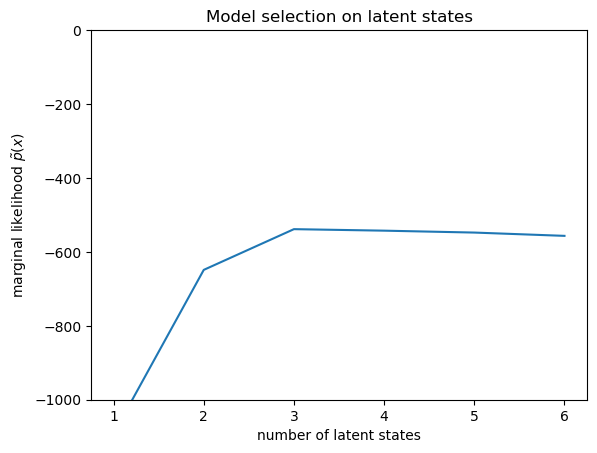

In [565]:
num_states = np.arange(1, max_num_states+1)
plt.plot(num_states, -loss)
plt.ylim([-1000, 0])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states")
# plt.savefig('Toy_synthetic_data_3_model_selection.png')

In [566]:
neg_loss = -loss
best_neg_loss = neg_loss[0]
bayes_factor_thresh = 1.3
for i in range(0,len(neg_loss)):
    curr_loss = neg_loss[i]
    bayes_factor =  best_neg_loss / curr_loss 
    print("-----------")
    print(f"bf : {bayes_factor}")
    print(f"curr_loss : {curr_loss}")
    state_model = i
    if bayes_factor > bayes_factor_thresh:
        best_neg_loss = curr_loss
        best_state_model = state_model
best_state_model      

-----------
bf : 1.0
curr_loss : -1091.9429931640625
-----------
bf : 1.6832844018936157
curr_loss : -648.6978759765625
-----------
bf : 1.204623818397522
curr_loss : -538.506591796875
-----------
bf : 1.1955631971359253
curr_loss : -542.5877075195312
-----------
bf : 1.1842988729476929
curr_loss : -547.7484741210938
-----------
bf : 1.1653612852096558
curr_loss : -556.6495971679688


1

In [567]:
posterior_probs = hmm.posterior_marginals(
    observed_counts).probs_parameter().numpy()
most_probable_states = np.argmax(posterior_probs, axis=-1)

In [568]:
rates

array([[ 25.882757 ,  12.384564 ,  22.907131 ,  18.785982 ,  29.68973  ,
         93.46421  ],
       [ 48.98578  ,  18.758287 ,  22.907131 ,  18.785982 ,  29.68973  ,
         93.46421  ],
       [ 48.997425 ,   2.3165052,  20.125135 ,  18.785982 ,  29.68973  ,
         93.46421  ],
       [ 48.997505 ,   2.3164232,  20.117641 ,  20.11733  ,  29.68973  ,
         93.46421  ],
       [ 20.10973  ,   2.3164027,  20.109806 ,  20.109941 ,  48.997917 ,
         93.46421  ],
       [  2.243156 ,   2.225937 ,  20.117695 ,  20.117542 , 210.43652  ,
         48.998898 ]], dtype=float32)

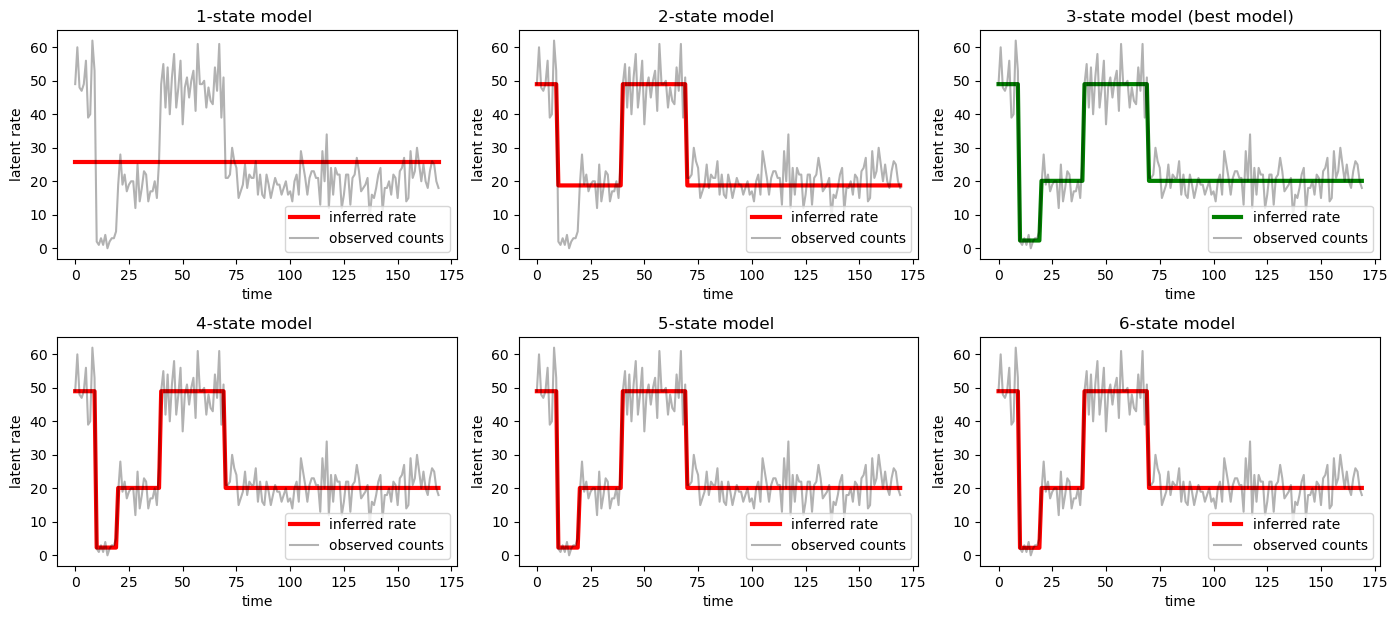

In [569]:
fig = plt.figure(figsize=(14, 12))
for i, learned_model_rates in enumerate(rates):
  ax = fig.add_subplot(4, 3, i+1)
  color = "red"
  title = ""
  if i == 2:
    color = "green"
    title = "(best model)"
  ax.plot(learned_model_rates[most_probable_states[i]], c=color, lw=3, label='inferred rate')
  ax.plot(observed_counts, c='black', alpha=0.3, label='observed counts')
  ax.set_ylabel("latent rate")
  ax.set_xlabel("time")
  ax.set_title(f"{i+1}-state model {title}")
  ax.legend(loc=4)
plt.tight_layout()
plt.savefig('Toy_synthetic_data_3_best_model.png')

# observed_counts1 = observed_counts
# most_probable_states1 = most_probable_states
# rate1 = rates[2][most_probable_states[2]]


observed_counts2 = observed_counts
most_probable_states2 = most_probable_states
rate2 = rates[2][most_probable_states[2]]


In [657]:
def cleanCluster(rates,name):
    df = pd.DataFrame()
    df["count"] = rates
    df["fname"] = name
    df["window"] = df.index

    df["count_test"] = np.where(df["count"] != df["count"].shift(1),True,False)
    df.iloc[-1, df.columns.get_loc('count_test')] = True
    df = df[df["count_test"]==True]
    df["label"] = 1
    df["label"] = df["label"].cumsum(axis = 0)
    df["label"] = df["fname"] + "_" + df["label"].astype(str)
    del df["count_test"]
    return df

df1 = cleanCluster(rates=rate1, name="Control")

df2 = cleanCluster(rates=rate2, name="Treatment")
# df2
# print(df1)

# rate2
# plt=sns.scatterplot(data=df2, x="window", y="count", hue="cluster_label",palette=("tab10"),style="fname",s=500) 
# sns.lineplot(x="window", y="count", data=df,hue="fname",palette=palette,alpha=0.3)

In [658]:
# df_merge = pd.concat([df1,df2])
# df_merge

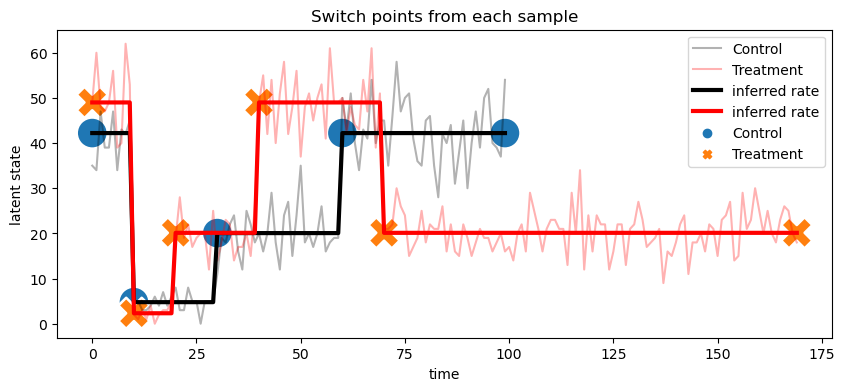

In [673]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(observed_counts1, c='black', alpha=0.3, label='Control')
ax.plot(observed_counts2, c='red', alpha=0.3, label='Treatment')
ax.plot(rate1, c="black", lw=3, label='inferred rate')
ax.plot(rate2, c="red", lw=3, label='inferred rate')
sns.scatterplot(data=df_merge, x="window", y="count", hue="fname",palette=("tab10"),style="fname",s=500) 
ax.set_ylabel("latent state")
ax.set_xlabel("time")
ax.set_title("Switch points from each sample")
ax.legend(loc=1)
plt.savefig('Toy_synthetic_dbscan_1.png',dpi=1200)



,count,fname,window,label,cluster_label
0,42.217087,Control,0,Control_1,1
0,48.997425,Treatment,0,Treatment_1,2
10,4.774477,Control,10,Control_2,3
10,2.316505,Treatment,10,Treatment_2,3
20,20.125135,Treatment,20,Treatment_3,4
30,20.068520,Control,30,Control_3,4
40,48.997425,Treatment,40,Treatment_4,5
60,42.217087,Control,60,Control_4,6
70,20.125135,Treatment,70,Treatment_5,7
99,42.217087,Control,99,Control_5,8


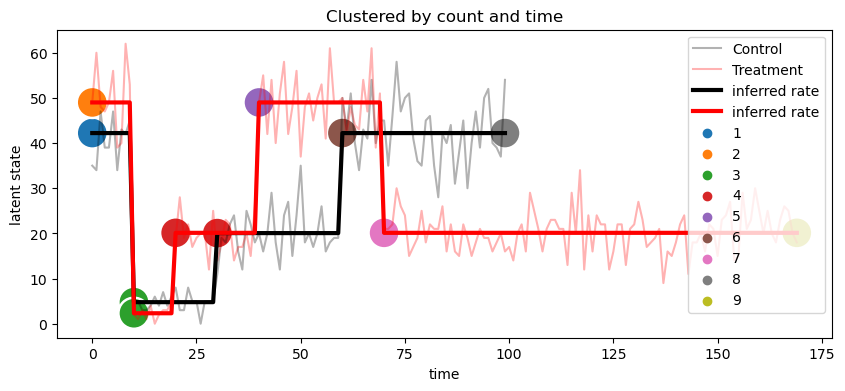

In [674]:

df2 = df_merge.copy()
df2 = df2.sort_values(by=["window"], ascending=True)  
z = df2[["count","window"]].to_numpy()         
X = StandardScaler().fit_transform(z)


db = DBSCAN(eps=0.3, min_samples=1).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

#         print("Silhouette Coefficient: %0.3f"% metrics.silhouette_score(X, labels))
df2["cluster_label"] = labels   
df2["cluster_label"] = df2["cluster_label"] + 1        



fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(observed_counts1, c='black', alpha=0.3, label='Control')
ax.plot(observed_counts2, c='red', alpha=0.3, label='Treatment')
ax.plot(rate1, c="black", lw=3, label='inferred rate')
ax.plot(rate2, c="red", lw=3, label='inferred rate')
sns.scatterplot(data=df2, x="window", y="count", hue="cluster_label",palette=("tab10"),s=500) 
ax.set_ylabel("latent state")
ax.set_xlabel("time")
ax.set_title("Clustered by count and time")
ax.legend(loc=1)
# sns.scatterplot(data=df2, x="window", y="count", hue="cluster_label",palette=("tab10"),style="fname",s=500) 
    
plt.savefig('Toy_synthetic_dbscan_2.png',dpi=1200)
df2

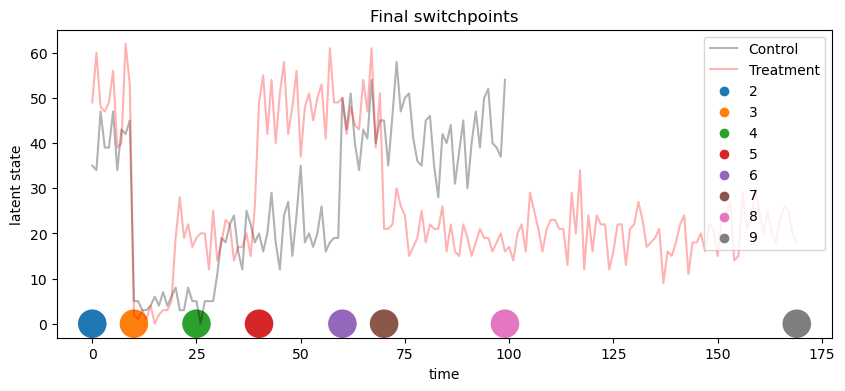

In [675]:

df3 = df2.copy()

df3['window'] = df3['window'].groupby(df2['cluster_label']).transform('mean')  
# df3['window'] = df3['window'].groupby(df2['cluster_label']).transform('mean')  
max_window = df3["window"].max()     
df3 = df3.drop_duplicates(subset=["cluster_label"])        
df3 = df3.sort_values(by=["window"], ascending=True)
df3.iloc[0, df3.columns.get_loc('window')] = 1      
df3.iloc[-1, df3.columns.get_loc('window')] = max_window 

df3 = df3.sort_values(by=["window"], ascending=True)         
df3 = df3[df3["window"]!=1]
df3 = df3.drop_duplicates(subset=["cluster_label"]) 
df3 = df3.reset_index(drop=True)
df3["latent_state"] = df3.index + 1
df3["latent_state"] = df3["latent_state"].astype(int)
df3["first_last_state"] = "middle"


if len(df3) == 1:
    df3["first_last_state"] = "single"

if len(df3) > 1:
    df3.iloc[0, df3.columns.get_loc('first_last_state')] = "start"    
    df3.iloc[-1, df3.columns.get_loc('first_last_state')] = "end"        
      
        
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)

ax.plot(observed_counts1, c='black', alpha=0.3, label='Control')
ax.plot(observed_counts2, c='red', alpha=0.3, label='Treatment')
# ax.plot(rate1, c="black", lw=3, label='inferred rate')
# ax.plot(rate2, c="red", lw=3, label='inferred rate')
df3["count"] = 0
sns.scatterplot(data=df3, x="window", y="count", hue="cluster_label",palette=("tab10"),s=500) 
ax.set_ylabel("latent state")
ax.set_xlabel("time")
ax.set_title("Final switchpoints")
ax.legend(loc=1)
# sns.scatterplot(data=df2, x="window", y="count", hue="cluster_label",palette=("tab10"),style="fname",s=500) 
        
plt.savefig('Toy_synthetic_dbscan_3.png',dpi=1200)
# df3.to_csv(f'{name}_FinalSwitchpoints.tsv',sep="\t",index=None)      

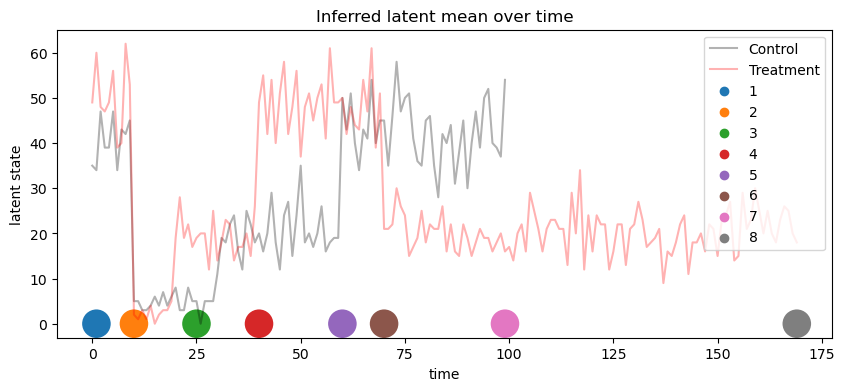

In [641]:

df4 = df3.copy()




z = df4[["window"]].to_numpy()         
X = StandardScaler().fit_transform(z)
# Compute DBSCAN
db = DBSCAN(eps=.1, min_samples=1).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_


df4["cluster_label"] = labels   
df4["cluster_label"] = df4["cluster_label"] + 1

        
df4 = df4.drop_duplicates(subset=["cluster_label"])        
df4 = df4.sort_values(by=["window"], ascending=True)
df4.iloc[0, df4.columns.get_loc('window')] = 1      
df4.iloc[-1, df4.columns.get_loc('window')] = max_window 

df4 = df4.sort_values(by=["window"], ascending=True)         
# df4 = df4[df4["window"]!=1]
df4 = df4.reset_index(drop=True)
df4["latent_state"] = df4.index + 1
df4["cluster_label"] = df4["latent_state"].astype(int)
df4["first_last_state"] = "middle"


df4["count"] = 0

df4['window'] = df4['window'].groupby(df4['cluster_label']).transform('mean')  
# df3['window'] = df3['window'].groupby(df2['cluster_label']).transform('mean')  
max_window = df4["window"].max()     
df4 = df4.drop_duplicates(subset=["cluster_label"])        
df4 = df4.sort_values(by=["window"], ascending=True)



        
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(observed_counts1, c='black', alpha=0.3, label='Control')
ax.plot(observed_counts2, c='red', alpha=0.3, label='Treatment')
# ax.plot(rate1, c="black", lw=3, label='inferred rate')
# ax.plot(rate2, c="red", lw=3, label='inferred rate')
df4["count"] = 0
sns.scatterplot(data=df4, x="window", y="count", hue="cluster_label",palette=("tab10"),s=500) 
ax.set_ylabel("latent state")
ax.set_xlabel("time")
ax.set_title("Inferred latent mean over time")
ax.legend(loc=1)
# sns.scatterplot(data=df2, x="window", y="count", hue="cluster_label",palette=("tab10"),style="fname",s=500) 
        
plt.savefig('Toy_synthetic_dbscan_3.png')
# df3.to_csv(f'{name}_FinalSwitchpoints.tsv',sep="\t",index=None)    